<a href="https://colab.research.google.com/github/SubhraSMukherjee/Brand_Lift/blob/main/Brand_Lift_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from itertools import product
import warnings
import matplotlib.pyplot as plt
from sklearn import preprocessing as pre
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
SalesData = pd.read_csv("/content/Advertising_Data.csv")
SalesData

,TV,Billboards,Google_Ads,Social_Media,Influencer_Marketing,Affiliate_Marketing,Product_Sold
0,281.42,538.80,123.94,349.30,242.77,910.10,7164.0
1,702.97,296.53,558.13,180.55,781.06,132.43,5055.0
2,313.14,295.94,642.96,505.71,438.91,464.23,6154.0
3,898.52,61.27,548.73,240.93,278.96,432.27,5480.0
4,766.52,550.72,651.91,666.33,396.33,841.93,9669.0
...,...,...,...,...,...,...,...
295,770.05,501.36,694.60,172.26,572.26,410.56,6851.0
296,512.38,250.83,373.78,366.95,987.14,509.03,6477.0
297,998.10,858.75,781.06,60.61,174.63,213.53,6949.0
298,322.35,681.22,640.29,343.65,534.22,648.71,7737.0


In [ ]:
x = SalesData.Social_Media.values.reshape(-1, 1)
x_norm = pre.MinMaxScaler(feature_range=(0.65, 0.9)).fit_transform(x)
SalesData['Brand_Searches'] = [np.random.normal(loc=(100*loc), scale=2.0).item(0) for loc in x_norm]

In [ ]:
SalesData

,TV,Billboards,Google_Ads,Social_Media,Influencer_Marketing,Affiliate_Marketing,Product_Sold,Brand_Searches
0,281.42,538.80,123.94,349.30,242.77,910.10,7164.0,73.821769
1,702.97,296.53,558.13,180.55,781.06,132.43,5055.0,70.104524
2,313.14,295.94,642.96,505.71,438.91,464.23,6154.0,78.819528
3,898.52,61.27,548.73,240.93,278.96,432.27,5480.0,67.167331
4,766.52,550.72,651.91,666.33,396.33,841.93,9669.0,81.910911
...,...,...,...,...,...,...,...,...
295,770.05,501.36,694.60,172.26,572.26,410.56,6851.0,71.738332
296,512.38,250.83,373.78,366.95,987.14,509.03,6477.0,72.953347
297,998.10,858.75,781.06,60.61,174.63,213.53,6949.0,67.146964
298,322.35,681.22,640.29,343.65,534.22,648.71,7737.0,73.796359


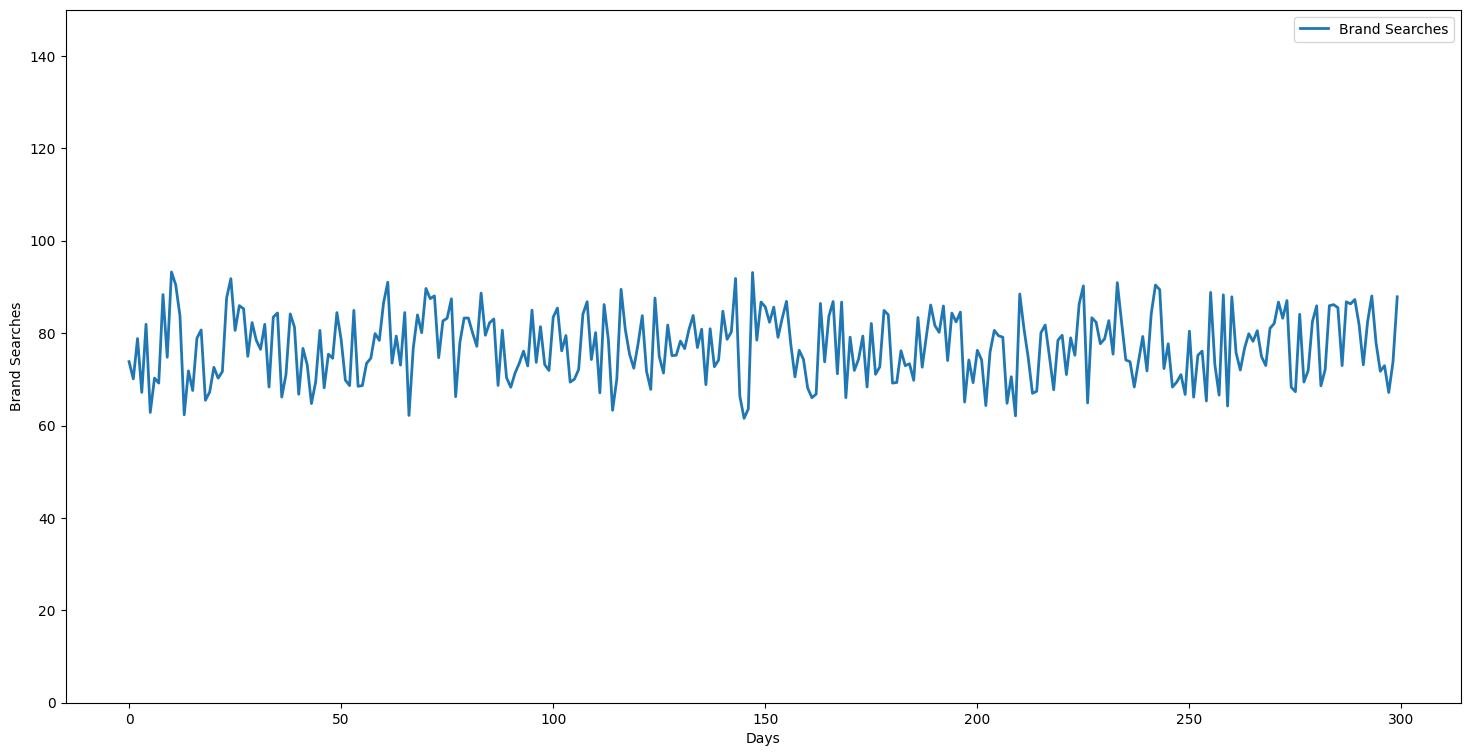

In [ ]:
plt.figure(figsize=(18, 9))
plt.plot(list(SalesData.index), SalesData.Brand_Searches, linewidth=2, label = "Brand Searches")
plt.ylim(0, 150)
plt.ylabel("Brand Searches")
plt.xlabel("Days")
plt.legend()
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller
def check_stationarity(series):

    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/
    # https://colab.research.google.com/drive/1FpokEJSDkaWB21wz5l-H6mxT27bUmNfo?usp=sharing

    result = adfuller(series.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

check_stationarity(SalesData.Brand_Searches)

ADF Statistic: -15.785469
p-value: 0.000000
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572
Stationary


>## Sarimax Formulation
\begin{split}y_t & = \beta_t x_t + u_t \\
\phi_p (L) \tilde \phi_P (L^s) \Delta^d \Delta_s^D u_t & = A(t) +
    \theta_q (L) \tilde \theta_Q (L^s) \zeta_t\end{split}

where parameters to be estimated

>\begin{align}
        \text{Sarimax}(y,x) = \left\{
        \begin{array}{cl}
        \beta_t & \beta_t > 0 \\
        \begin{split}\Phi (L) \equiv \phi_p (L) \tilde \phi_P (L^s) \\
\Theta (L) \equiv \theta_q (L) \tilde \theta_Q (L^s)\end{split}
        \end{array}
        \right.
    \end{align}

In [ ]:
warnings.filterwarnings("ignore")
p = q = range(0, 4)
d =  range(0, 1)
pdq = list(product(p, d, q))
PDQs = [(x[0], x[1], x[2], 7) for x in list(product(p, d, q))] #Daily data so seasonality is assumed to be 7
exogenous = ['Social_Media'] #[x for x in SalesData.columns.tolist() if x not in ('Product_Sold','Brand_Searches')]

model_specification = []
def SarimaxGridSearch(pdq, PDQs, maxiter=10000, freq='D'):
       for element in pdq:
              for element2 in PDQs:
                     try:
                        model = SARIMAX(SalesData.Brand_Searches, exog = SalesData[exogenous], order = element, seasonal_order = element2, trend='n', enforce_stationarity=False, enforce_invertibility=False, mle_regression = True)
                        results = model.fit(maxiter = maxiter)
                        results_as_html = results.summary().tables[1].as_html()
                        results_DF = pd.read_html(results_as_html, header=0, index_col=0)[0]
                        if float(results_DF['coef']['Social_Media']) > 0:
                          model_specification.append([element, element2, results.bic])
                     except:
                        continue

       Model_df = pd.DataFrame(model_specification, columns=['pdq', 'PDQs', 'bic']).sort_values(by=['bic'],ascending=True)[0:10]
       return Model_df.reset_index(drop=True)

best_model = SarimaxGridSearch(pdq, PDQs)
best_model

,pdq,PDQs,bic
0,"(1, 0, 3)","(0, 0, 3, 7)",1225.448270
1,"(3, 0, 3)","(0, 0, 3, 7)",1234.411970
2,"(2, 0, 1)","(3, 0, 1, 7)",1236.403762
3,"(1, 0, 1)","(3, 0, 2, 7)",1236.893121
4,"(2, 0, 3)","(0, 0, 3, 7)",1237.657806
5,"(0, 0, 0)","(1, 0, 3, 7)",1240.865129
6,"(3, 0, 2)","(1, 0, 3, 7)",1241.141392
7,"(1, 0, 1)","(3, 0, 3, 7)",1241.750013
8,"(3, 0, 3)","(3, 0, 0, 7)",1242.243430
9,"(1, 0, 2)","(0, 0, 3, 7)",1242.682948


In [ ]:
model_final = SARIMAX(SalesData.Brand_Searches, exog = SalesData[exogenous], order = best_model.loc[0, 'pdq'], seasonal_order = best_model.loc[0, 'PDQs'], trend='n', enforce_stationarity=False, enforce_invertibility=False, mle_regression = True)
results = model_final.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                    Brand_Searches   No. Observations:                  300
Model:             SARIMAX(1, 0, 3)x(0, 0, 3, 7)   Log Likelihood                -721.045
Date:                           Tue, 16 Sep 2025   AIC                           1460.089
Time:                                   17:42:12   BIC                           1492.640
Sample:                                        0   HQIC                          1473.153
                                           - 300                                         
Covariance Type:                             opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Social_Media     0.0257      0.000     51.397      0.000       0.025       0.027
ar.L1            0.9994      0.001   

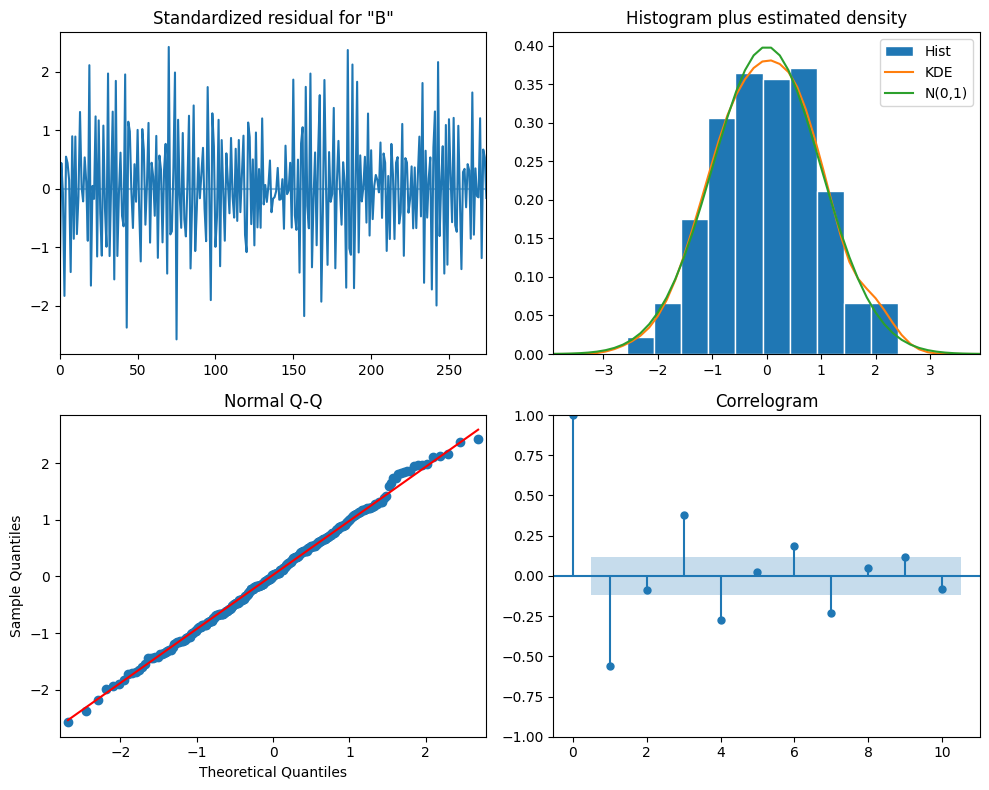

In [ ]:
results.plot_diagnostics(figsize=(10,8)).tight_layout()

In [ ]:
results_as_html = results.summary().tables[1].as_html()
results_DF = pd.read_html(results_as_html, header=0, index_col=0)[0]
val = pd.Series(SalesData.Social_Media.values)
minimum_effective_spend = float(np.mean(SalesData.Brand_Searches)*0.05/results_DF['[0.025']['Social_Media'])

In [ ]:
counterfactual = np.where((SalesData.Brand_Searches - (val.multiply(float(results_DF['coef']['Social_Media']), fill_value=0))) < 0 , np.nan, (SalesData.Brand_Searches - (val.multiply(float(results_DF['coef']['Social_Media']), fill_value=0))))

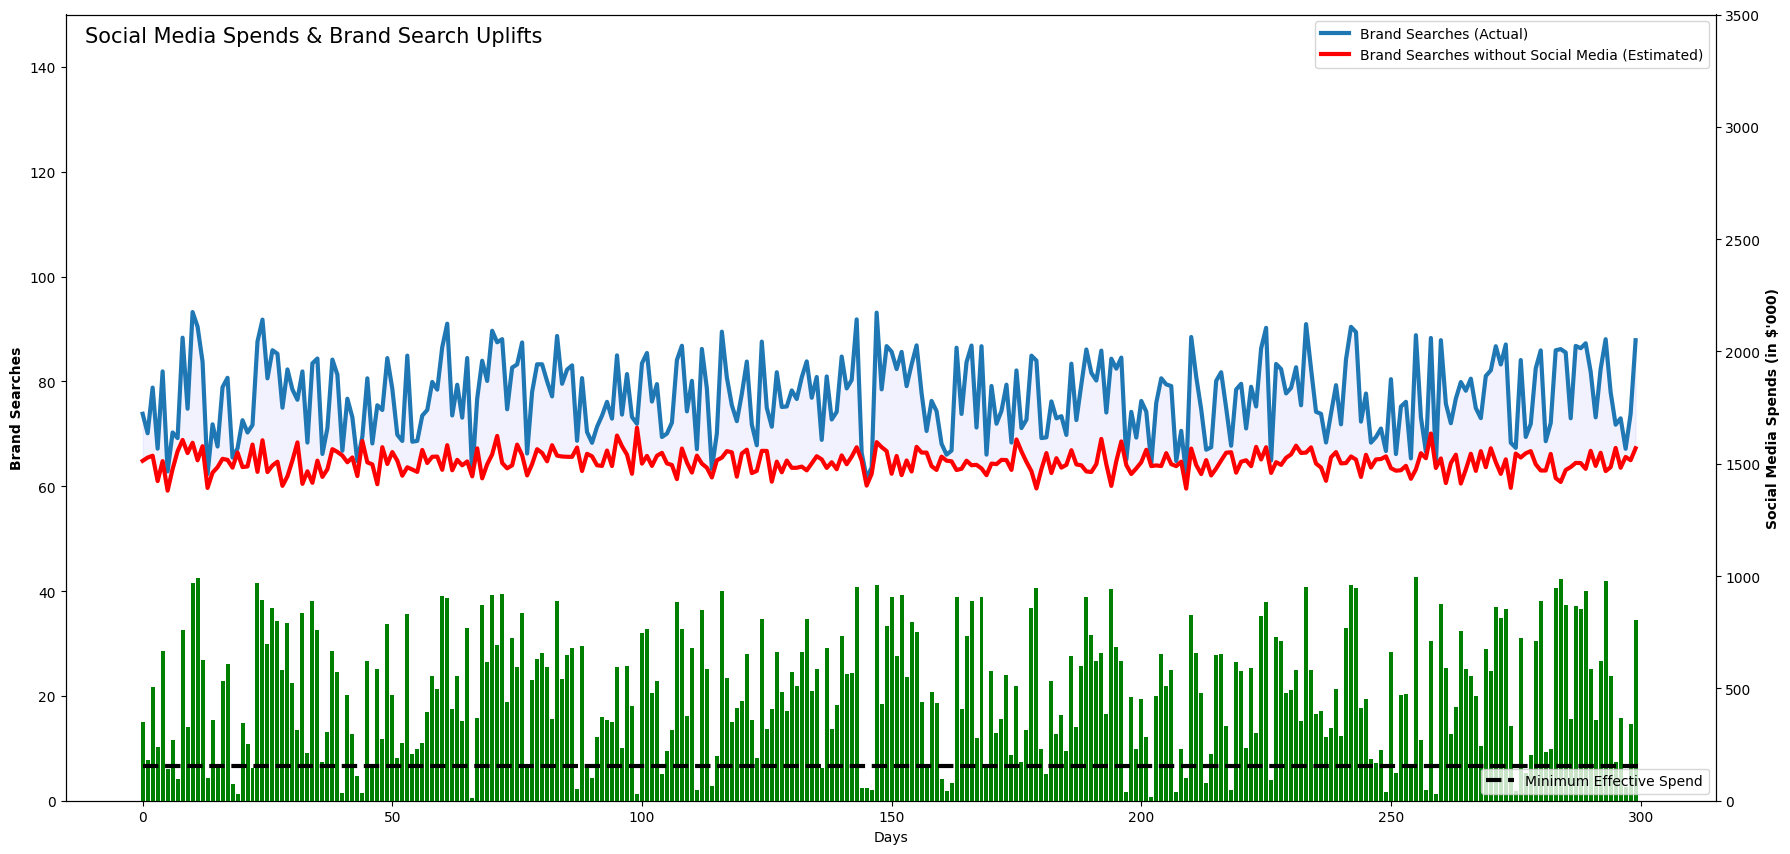

In [ ]:
fig, ax1 = plt.subplots(figsize=(18, 9))
#plt.figure(figsize=(18, 9))
ax1.plot(list(SalesData.index), SalesData.Brand_Searches, linewidth=3, label = "Brand Searches (Actual)")
ax1.plot(list(SalesData.index), counterfactual, linewidth=3, color="red", label = "Brand Searches without Social Media (Estimated)")
ax1.fill_between(list(SalesData.index), SalesData.Brand_Searches, counterfactual, color='blue', alpha=0.05)
ax1.set_ylim(0, 150)
ax1.set_ylabel("Brand Searches", fontweight="bold")
ax1.set_xlabel("Days")
ax1.legend()

ax2 = ax1.twinx()
ax2.bar(list(SalesData.index), SalesData.Social_Media,color="green")
ax2.set_ylim(0, 3500)
ax2.hlines(y=minimum_effective_spend, xmin=0, xmax=len(list(SalesData.index)), colors='black', linestyles='--', lw=3, label='Minimum Effective Spend')
ax2.legend(loc="lower right")
ax2.set_ylabel("Social Media Spends (in $'000)", fontweight="bold")

fig.suptitle('Social Media Spends & Brand Search Uplifts', x=0.05, y=.925, horizontalalignment='left', verticalalignment='top', fontsize = 15)
fig.tight_layout()
plt.show()